# **Medical cost prediction**

Dataset used: https://www.kaggle.com/datasets/mirichoi0218/insurance

In this project I will develop a machine learning model to predict the cost of medical insurance based on the following features:


*   **age**: age of primary beneficiary
*   **sex**: insurance contractor gender
*   **bmi**: Body mass index using the ratio of height to weight, ideally 18.5 to 24.9
*   **children**: Number of children covered by health insurance / Number of dependents
*   **smoker**: Smoking
*   **region**: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)

Let's import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler


import missingno as msno

# Import Dataset

In [ ]:
!git clone https://github.com/SofiaFormenti/ML-Project

Cloning into 'ML-Project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 16.34 KiB | 8.17 MiB/s, done.


In [ ]:
medical_data = pd.read_csv('/content/ML-Project/insurance.csv')
medical_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's see the shape and general information of our dataset

In [ ]:
medical_data.shape

(1338, 7)

In [ ]:
medical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
medical_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Let's now see if the dataset has missing values (Null values)

In [ ]:
medical_data.isnull().sum(axis=0)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

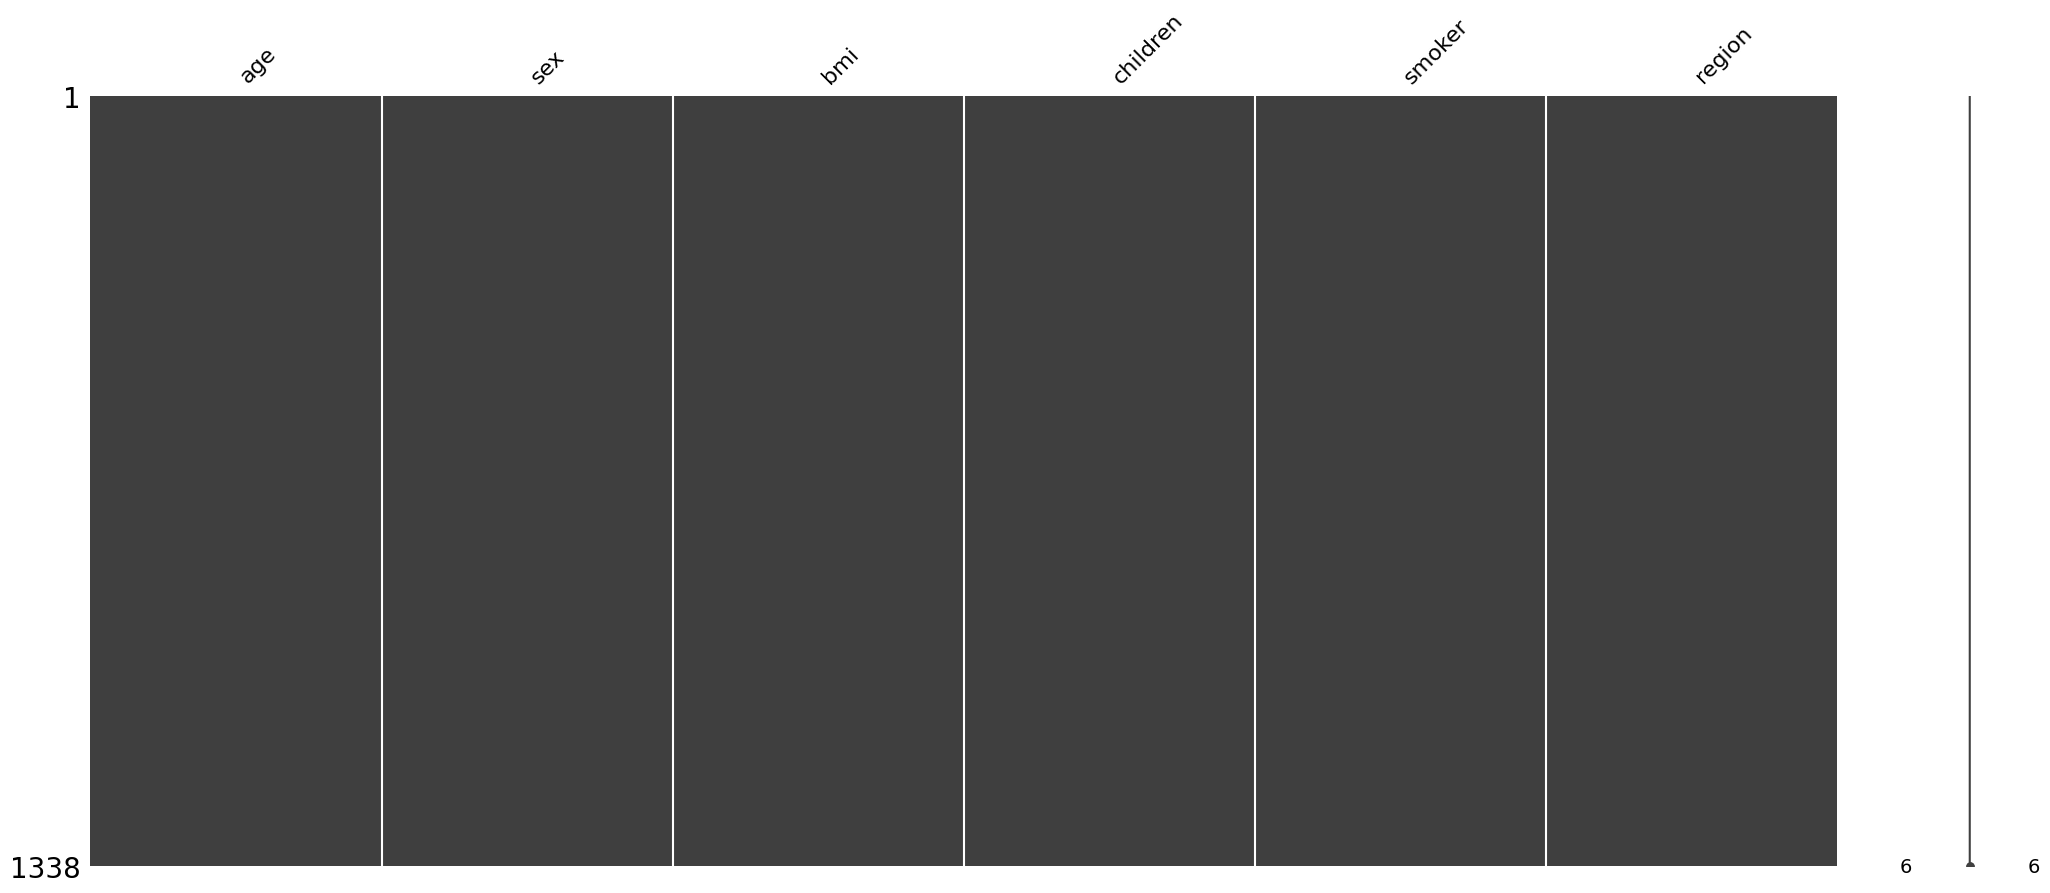

In [ ]:
X = medical_data.iloc[:, :-1]
y = medical_data.iloc[:, -1]

msno.matrix(X);

The dataset is completely clean, with no missing data. This is very positive, but to make the project more similar to real case scenarios, we will introduce some noise (imputing missing values).
Before doing this, let's analyze grafically our features, this will give us important information helpful for data preprocessing and make us understand useful correlations between features, giving us a more wide view of the problem at hand.

# Data visualization


*Histogram of frequency distribution of age*

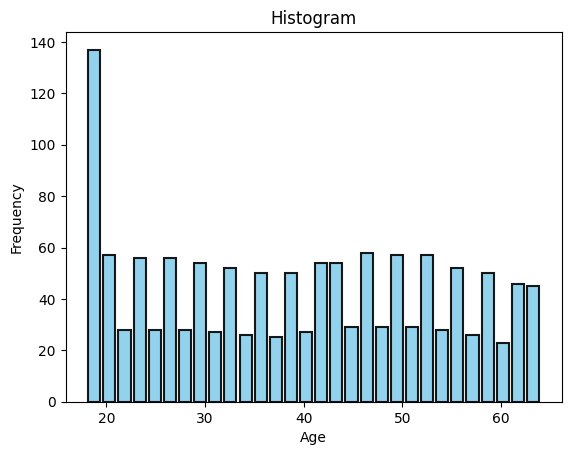

In [ ]:
# Histogram
plt.hist(medical_data['age'],
         bins=30,                       # Number of bins
         edgecolor='black',             # Color of edges
         linewidth=1.5,                 # Width of edge lines
         color='skyblue',               # Color of bars
         alpha=0.9,                     # Transparency of bars
         orientation='vertical',        # Orientation of the histogram ('horizontal' or 'vertical')
         rwidth=0.8,                    # Width of bars relative to bin width
         align='mid',                   # Alignment of bars with bin edges ('left', 'mid', 'right')
         )

plt.title('Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

*Density distribution of bmi*

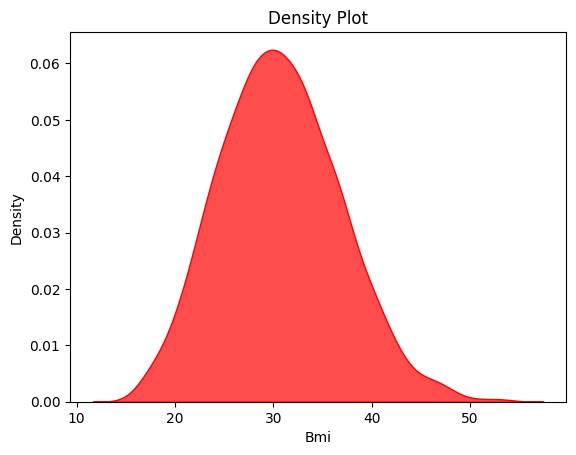

In [ ]:
# Density Plot
sns.kdeplot(medical_data['bmi'],
            fill=True,        # Whether to shade the area under the curve
            color='red',        # Color of the line
            alpha=0.7,        # Transparency of the shading
           )
plt.title('Density Plot')
plt.xlabel('Bmi')
plt.ylabel('Density')
plt.show()

*Scatterplot of bmi values*

As we can see the values aren't well compact, we have some outliers, this could be something to take into account for the performance of our model.

In fact if the outliers aren't removed or normalized they could hinder performance and potentially cause **overfitting** (the model might become overly complex in an attempt to fit these outliers, resulting in overfitting where the model performs well on training data but poorly on unseen data) and also **reduced robustness** (models become less robust and less reliable when they are sensitive to extreme values)

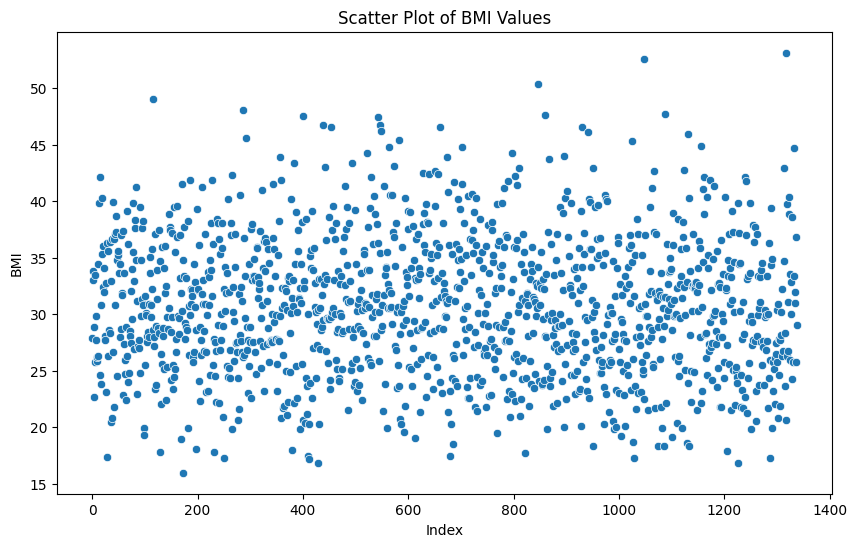

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=medical_data.index, y='bmi', data=medical_data)
plt.title('Scatter Plot of BMI Values')
plt.xlabel('Index')
plt.ylabel('BMI')
plt.show()

Further plot to underline existence of some outliers in the bmi feature:

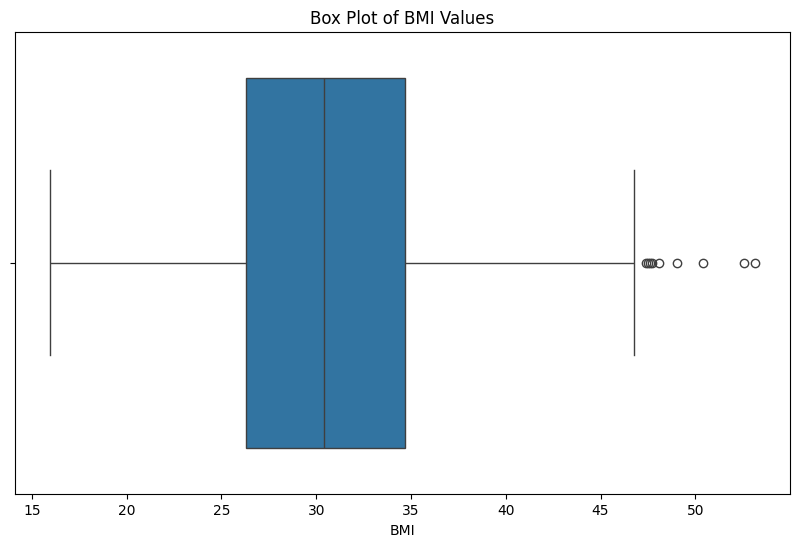

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=medical_data['bmi'])
plt.title('Box Plot of BMI Values')
plt.xlabel('BMI')
plt.show()

*Categorical values distribution*

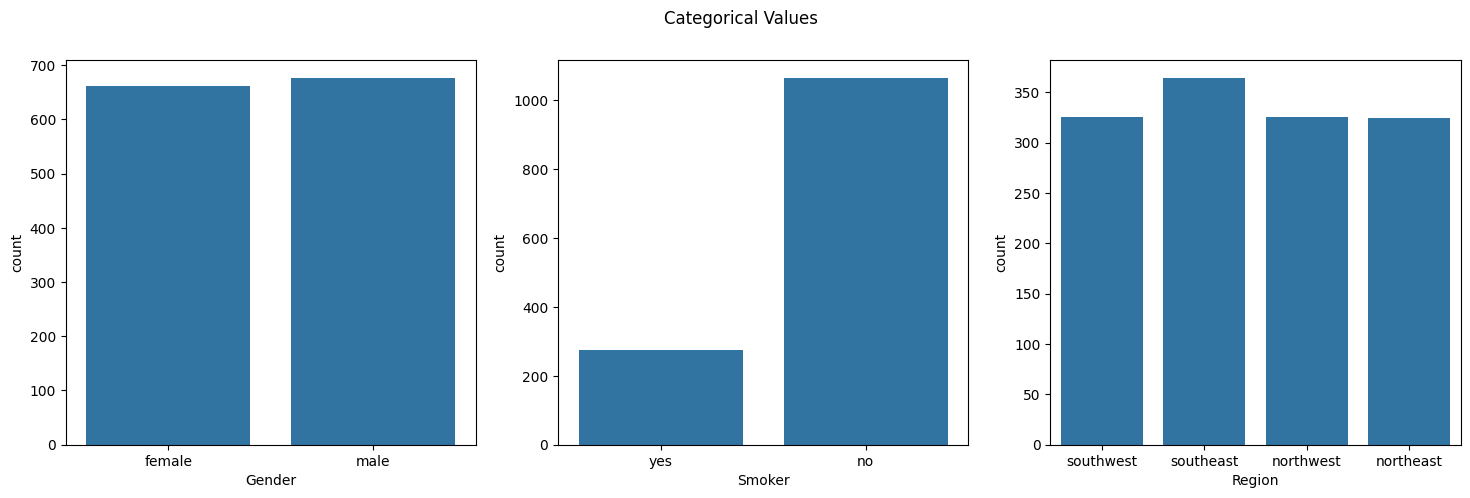

In [ ]:

plt.figure(figsize=(18, 5))

# Subplot 1: Countplot for 'sex'
plt.subplot(1, 3, 1)
sns.countplot(x='sex', data=medical_data)
plt.xlabel('Gender')

# Subplot 2: Countplot for 'smoker'
plt.subplot(1, 3, 2)
sns.countplot(x='smoker', data=medical_data)
plt.xlabel('Smoker')

# Subplot 3: Countplot for 'region'
plt.subplot(1, 3, 3)
sns.countplot(x='region', data=medical_data)
plt.xlabel('Region')

plt.suptitle('Categorical Values')
plt.show()

It seems that they are all quite balanced exept for the smokers feature, the ratio of smokers to non-smokers is 1:4.

Imbalanced datasets can lead to several issues, including a **biased model** towards the majority class (non-smokers in this case) and may not perform well on the minority class (smokers). Also **poor generalization**: the model might not generalize well to unseen data, especially when predicting the minority class and **misleading performance metrics** like accuracy. For example, a model that predicts the majority class for all instances would still have a high accuracy but would perform poorly on the minority class.



Some methods to handle imbalanced data are resampling techniques (oversampling and undersampling) and using ensamble methods like Random Forest Regressor

*Distribution of charges with respect to age*


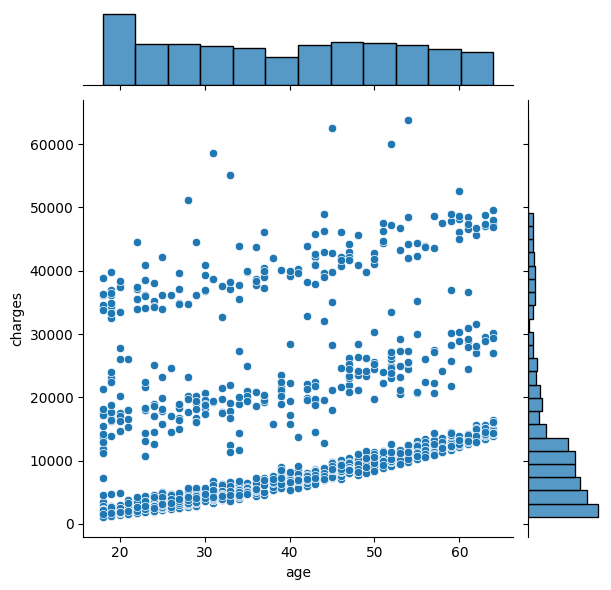

In [ ]:
sns.jointplot(x='age', y='charges', data=medical_data, kind='scatter')
plt.show()

*Distribution of charges with respect to age with smoker feature*

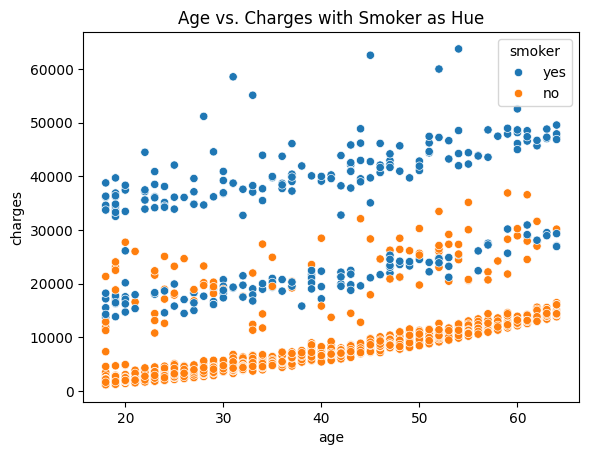

In [ ]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=medical_data) # 'hue' uses the 'smoker' variable to differentiate points by color.
plt.title('Age vs. Charges with Smoker as Hue')
plt.show()

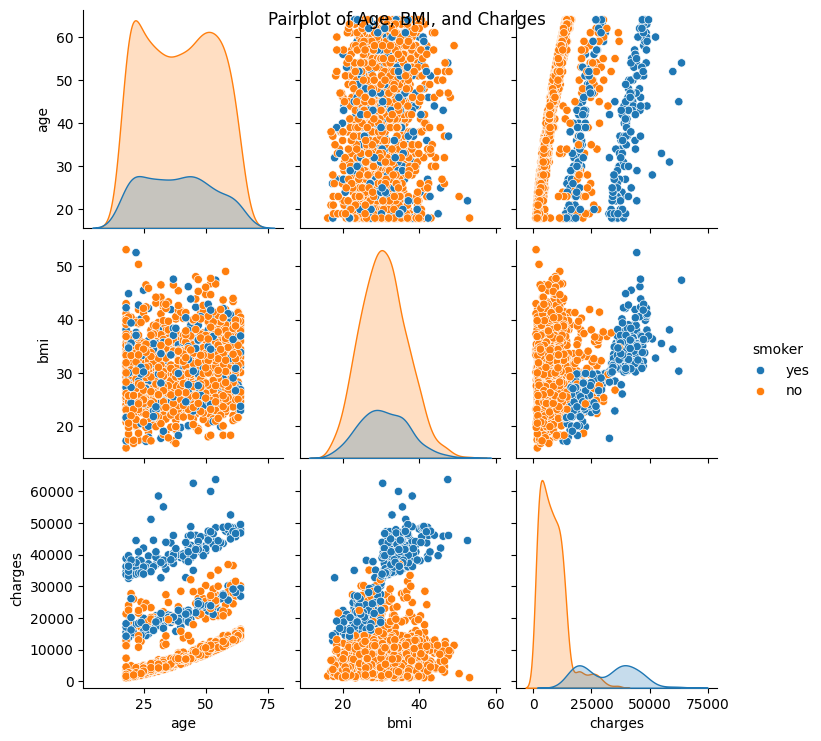

In [ ]:
sns.pairplot(medical_data, vars=['age', 'bmi', 'charges'], hue='smoker')
plt.suptitle('Pairplot of Age, BMI, and Charges')
plt.show()

*Correlation Matrix*

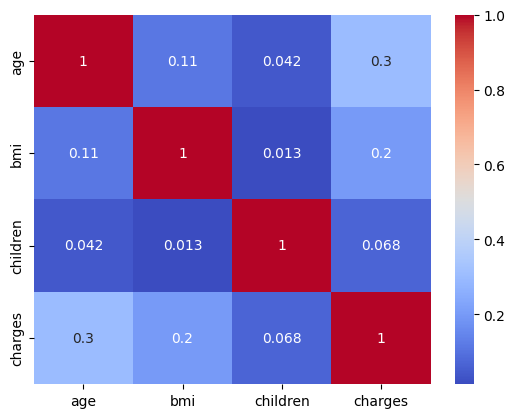

In [ ]:
correlation_matrix = medical_data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

- The moderate positive correlation between age and charges indicates that older individuals tend to have higher medical charges.
- There is a weak positive correlation between BMI and charges. As BMI increases, charges tend to increase slightly.
- There is a very weak positive correlation between the number of children and charges.

The low correlation values don't necessarily mean the features are unimportant. They might still be useful in a more complex, non-linear model or in combination with other features.

This should be kept into consideration if we want to take some actions such as feature engineering for creating interaction terms or polynomial features (typical non-linear relationships is suspected)

In cases like this its useful to use machine learning models capable of capturing non-linear relationships, such as Random Forests or Gradient Boosting Machines, all of which we will analyse into detail later in the project

# Missing values

Let's now make our dataset a bit noisy, it's important to understand how to handle missing values

In [ ]:
#define add_missing function to create some noise

def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [ ]:
noise_df = medical_data.copy() # avoid modifying the initial dataframe

#We are interested only in creating noise in the feature vectors, not in the label
for col in X:
  amount = np.random.uniform(0.0, 0.05)
  noise_df[col] = add_missing(noise_df[col], amount) # remove up to 5% of data from each column

print(noise_df.isnull().sum())

age         16
sex         50
bmi          8
children     3
smoker       3
region      37
charges      0
dtype: int64


<Axes: >

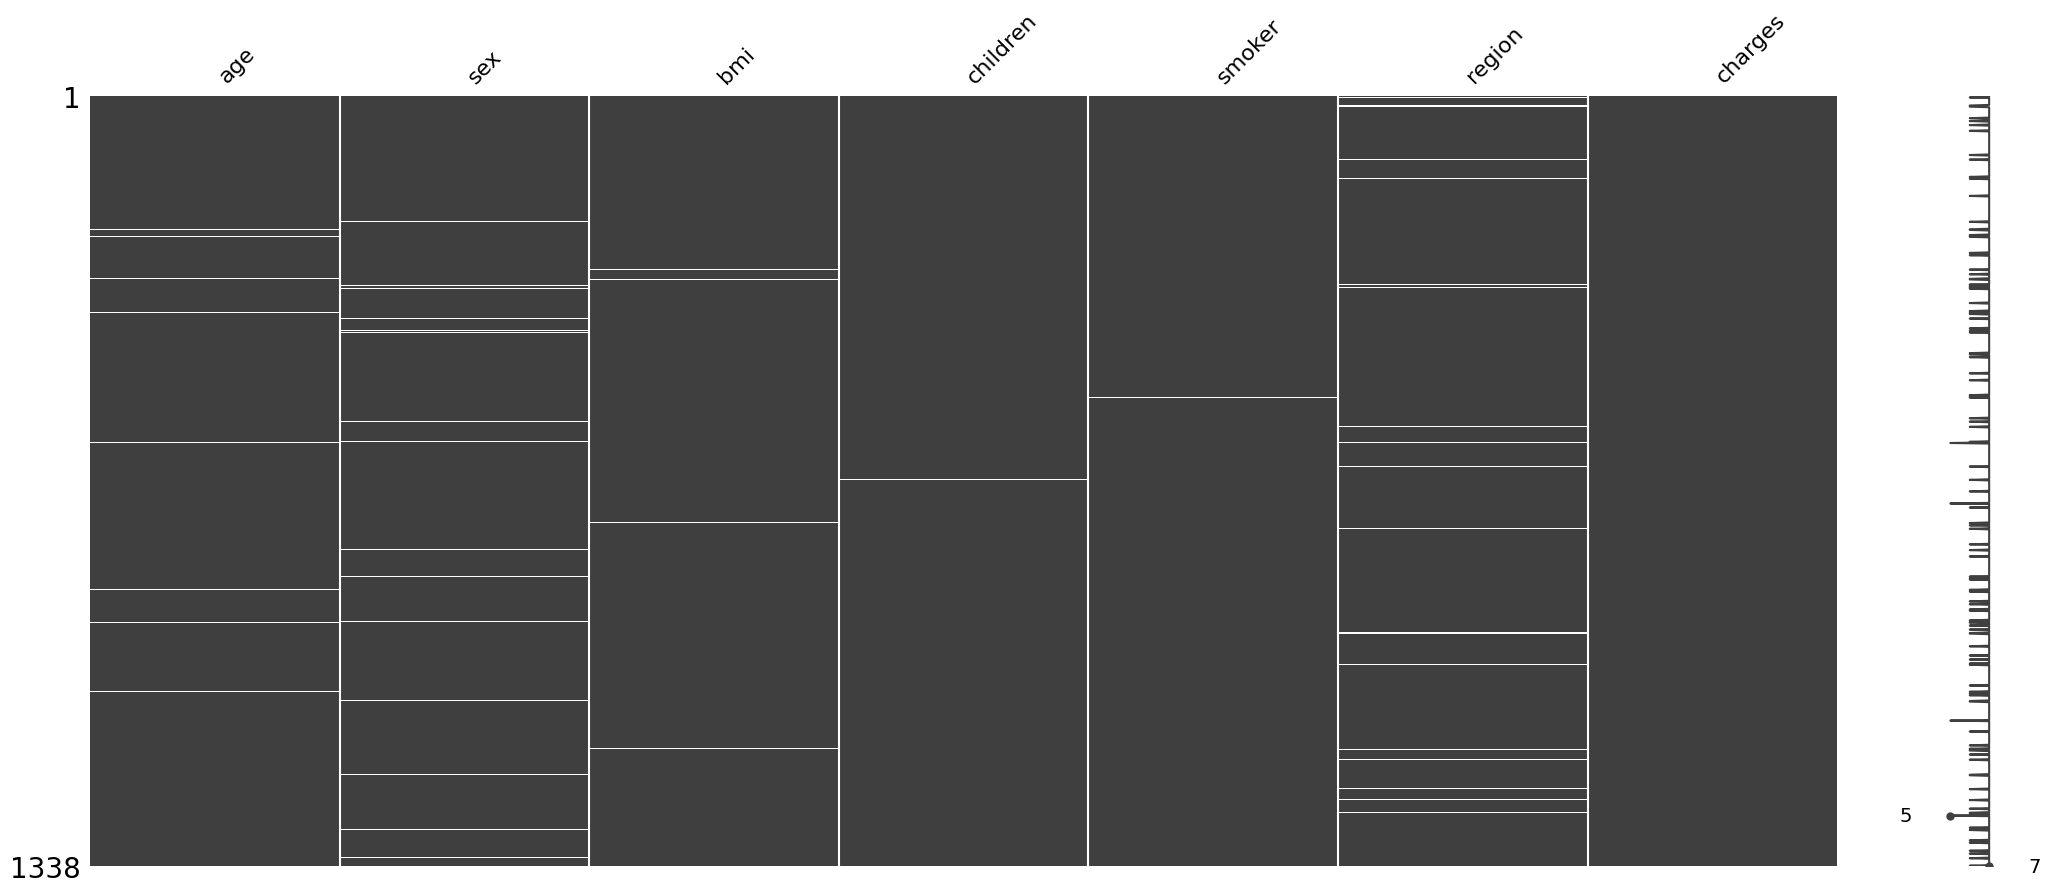

In [ ]:
msno.matrix(noise_df)

In [ ]:
X = noise_df.iloc[:, :-1]
y = noise_df['charges']

# Preprocessing Pipeline

Preprocessing is a very important step, to impute missing values and to standardize our data.
To make it clearer how I acted on data I drew a schematic overview of the actions to take:

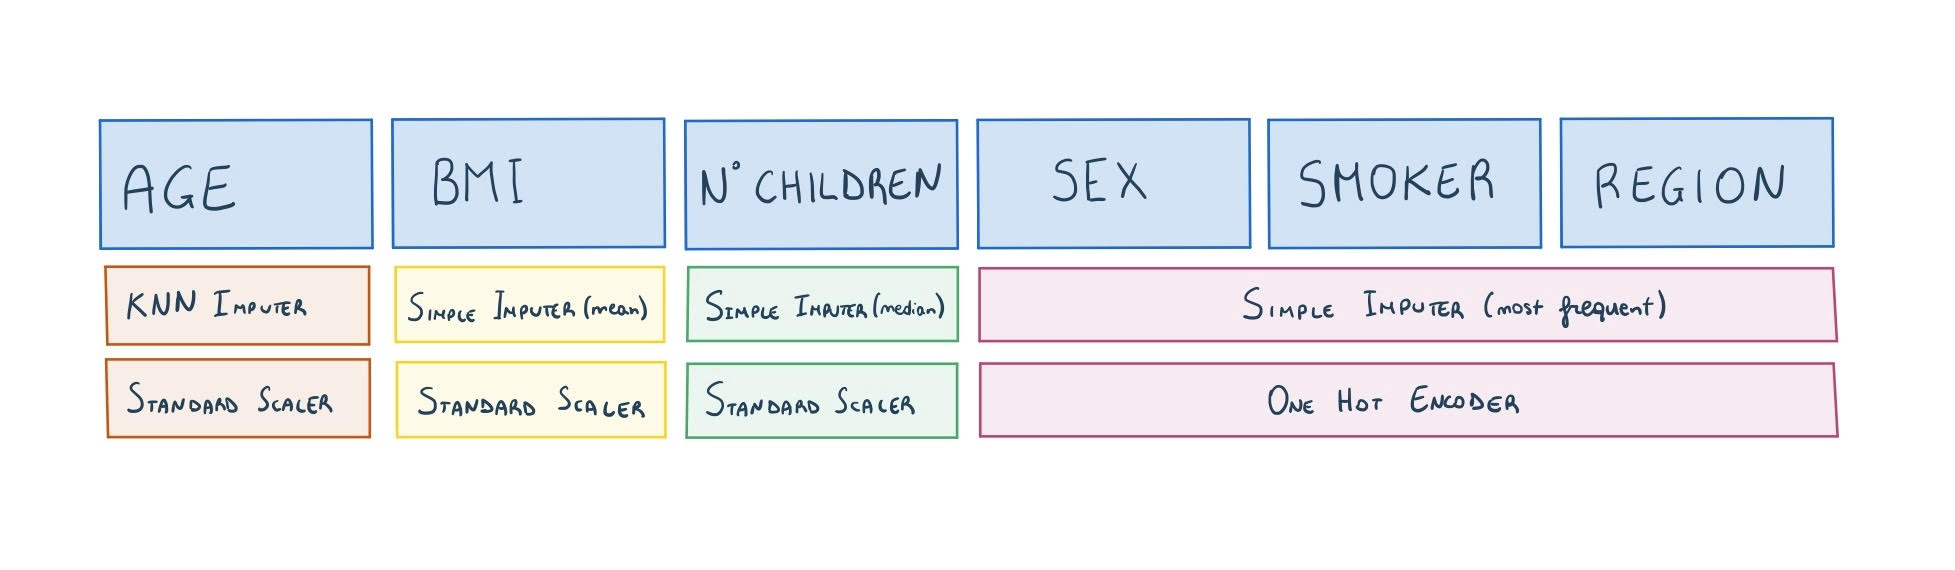

*Preprocessing pipeline*

In [ ]:
pipeline_age = Pipeline([
    ('imp', KNNImputer(n_neighbors=5) ),
    ('scaler', StandardScaler() )
])

pipeline_bmi = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler() )
])

pipeline_children = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler() )
])

pipeline_sex_smoker_region = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder() )
])

final_transformation = ColumnTransformer(transformers=[
    ('age', pipeline_age ,['age'] ),
    ('bmi', pipeline_bmi, ['bmi'] ),
    ('children', pipeline_children, ['children']),
    ('sex_smoker_region', pipeline_sex_smoker_region, ['sex','smoker','region'] )
],
verbose_feature_names_out=False,
sparse_threshold=0
)

# Training and Test set

This is a regression task, so I won't stratify my data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=30)

# Model Selection

Let's proceed by defining a starting model or pipeline and for sanity check, lets run the fit method and the predict to verify if errors occur.

In [ ]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', None),
    ('dim_reduction', PCA(n_components=0.8)),
    ('regressor', RandomForestRegressor())
])

# Train the regression pipeline
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('sex_smoker_region',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None), ('dim_reduction', PCA(n_components=0.8)),
                ('regressor', RandomForestRegressor())])

In [ ]:
y_pred= model_pipeline.predict(X_test)
y_pred

array([40537.2313038 ,  5141.660759  ,  8480.1879396 , 16441.117286  ,
       10228.5066682 ,  5244.7987051 ,  2355.15971971, 15573.0103617 ,
       42823.4968374 , 15554.6210613 ,  9147.7191684 , 12689.8736942 ,
       42813.158473  , 15983.5244625 ,  2024.0605739 , 27481.5982983 ,
       10160.9740994 , 12977.9656499 , 19447.8349745 , 10977.125452  ,
        1977.0140891 ,  7034.186363  , 10278.0295871 ,  8955.1155448 ,
       28386.8109213 , 44631.461824  , 12258.7532696 ,  4745.5155299 ,
        7795.4066823 , 16538.6339659 ,  4346.6243469 , 43508.5504961 ,
        2996.5707672 , 12473.6970334 , 12870.0178229 ,  7037.0064042 ,
        4382.8502481 ,  6892.454882  ,  2139.4940247 ,  6431.4898734 ,
        8452.3346911 , 37083.3988089 ,  2496.8609832 , 12503.5547478 ,
        6968.386295  , 40429.0862175 ,  8783.7461705 ,  1246.854944  ,
        4976.395308  ,  4533.6652819 ,  9607.3452093 ,  9641.8853643 ,
       13679.4233812 ,  2205.0950497 ,  8814.1155279 ,  9730.0795453 ,
      

In [ ]:
print("Mean Absolute Error:", mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:", mean_squared_error(y_test,y_pred))
print("Root mean squared Error:", np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 score:" ,r2_score(y_test,y_pred))

Mean Absolute Error: 2907.8472282204916
Mean Squared Error: 26107752.215528276
Root mean squared Error: 5109.574563065723
R2 score: 0.8307472361915309


It's time to define the configurations of the hyperparameters we use in the hyperparameter optimization phase of the model selection.

We have to test for different combinations of classification models, each with a different set of hyperparameters, different dimensionality reduction techniques, each with a different set of hyperparameters, and diffent methods to handle imbalanced classes. Here we skipped the sampler configurations for now and analysed dimensionality reduction and various Regressor models.

In [ ]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SelectKBest(f_regression)],
        'dim_reduction__k': [5, 7, 10]
    }
]

classifier_configs = [
    {
        'regressor': [LinearRegression()]
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    {
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
     {
        'regressor': [DecisionTreeRegressor()],
        'regressor__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
        'regressor__splitter': ['best', 'random'],
        'regressor__max_depth': [None, 5, 10, 30, 50],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [10, 50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30]
    },
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7, 9],
        'regressor__weights': ['uniform', 'distance'],
        'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    {
        'regressor': [SVR()]}
]

Now we can build a list of all possible configurations by putting all the elements together.

In [ ]:
all_configs = []
for configuration in itertools.product(dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 28'

In [ ]:
all_configs[:2]

[{'dim_reduction': [None], 'regressor': [LinearRegression()]},
 {'dim_reduction': [None],
  'regressor': [Ridge()],
  'regressor__alpha': [0.1, 1.0, 10.0]}]

In [ ]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=200,
    n_jobs=-1,
    cv = 2,
    scoring='neg_mean_squared_error'
)

In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='r2', cv = 5, return_estimator=True, verbose=3, error_score='raise')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
44 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblear

[CV] END ......................................., score=0.870 total time=  19.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.837 total time=  18.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.796 total time=  18.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.791 total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
56 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.866 total time=  19.3s


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
RandomForestRegressor(max_depth=30, n_estimators=50) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8702603841787857
----------
None
RandomForestRegressor(max_depth=20, n_estimators=50) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8370710481089159
----------
SelectKBest(k=5, score_func=<function f_regression at 0x7f5deabe3370>)
Decis

In [ ]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.9771838508705828, r2 on test set:0.8124266933764669
r2 on training set:0.9773589280057907, r2 on test set:0.8164629954211801
r2 on training set:0.8773147512903792, r2 on test set:0.8213135248567359
r2 on training set:0.8780278256672012, r2 on test set:0.8146403890778517
r2 on training set:0.977022370923947, r2 on test set:0.8124743332998234


I tried running it several times and always found that:
- the best performing regressor on training data is always RandomForestRegressor(0.95 in average), but it presents significant overfitting on test data (0.79 on average), this means a 0.16 difference in performance
- DecisionTreeRegressor performs worse on training data (0.83) but presents significant less overfitting on test data(0.82)

The other regressors never made it to the top five

Now i want to investigate RandomForestRegressor

In [ ]:
randomForestRegressor_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', PCA(n_components=0.8)),
    ('regressor', RandomForestRegressor())
])


dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SelectKBest(f_regression)],
        'dim_reduction__k': [5, 7, 10]
    }
]

forest_regressor_configs = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [20,50,100,200],
        'regressor__max_depth': [10,20,30,50],
        'regressor__min_samples_leaf': [1,2,4]
    }
]

random_grid = []
for configuration in itertools.product(dim_reduction_configs,forest_regressor_configs):
    # Merging of two dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    random_grid.append(dict(all_parameters))

rs_best = RandomizedSearchCV(randomForestRegressor_model_pipeline,
    param_distributions=random_grid,
    n_iter=200,
    n_jobs=-1,
    cv = 2,
    scoring='neg_mean_squared_error'
)

best_scores = cross_validate(rs_best, X_train, y_train, scoring='r2', cv = 5, return_estimator=True, verbose=3, error_score='raise')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
48 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.889 total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
54 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.853 total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
48 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.831 total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
58 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.821 total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
52 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/d

[CV] END ......................................., score=0.877 total time= 1.3min


In [ ]:
for index, estimator in enumerate(best_scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(best_scores['test_score'][index])
    print('-'*10)

None
RandomForestRegressor(max_depth=30, min_samples_leaf=4) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8887874700562635
----------
None
RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=200) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8533658799425272
----------
None
RandomForestRegressor(max_depth=20, min_sampl

In [ ]:
for estimator in best_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.918161870798931, r2 on test set:0.8377634652088854
r2 on training set:0.9184094147024872, r2 on test set:0.8377902106197673
r2 on training set:0.9179116327161104, r2 on test set:0.8385889422906403
r2 on training set:0.9187174679833494, r2 on test set:0.8384661415211804
r2 on training set:0.9184372339984058, r2 on test set:0.838708926368832


In [ ]:
rfr_best_model = IMBPipeline([
    ('trans', final_transformation),
    ('regressor', RandomForestRegressor(n_estimators= 200, max_depth= 30, min_samples_leaf= 4))
])

rfr_best_model.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('sex_smoker_region',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('regressor',
                 RandomForestRegressor(max_depth=30, min_samples_leaf=4,
                                       n_estimators=200))])

In [ ]:
r2_score(y_test, rfr_best_model.predict(X_test))

0.8370858376258437

I would like now to further investigate the decision tree regressor model

In [ ]:
decision_tree_regressor_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', PCA(n_components=0.8)),
    ('regressor', DecisionTreeRegressor())
])

# Define configurations for dimensionality reduction and decision tree regressor
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [SelectKBest(f_regression)],
        'dim_reduction__k': [5, 7, 10]
    }
]

decision_tree_regressor_configs = [
    {
        'regressor': [DecisionTreeRegressor()],
        'regressor__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
        'regressor__splitter': ['best', 'random'],
        'regressor__max_depth': [None, 5, 10, 30, 50],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
]

# Create the random grid
random_grid = []
for configuration in itertools.product(dim_reduction_configs, decision_tree_regressor_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    random_grid.append(dict(all_parameters))

# Define and run RandomizedSearchCV
decisionTree_best = RandomizedSearchCV(decision_tree_regressor_model_pipeline,
                             param_distributions=random_grid,
                             n_iter=200,
                             n_jobs=-1,
                             cv=2,
                             scoring='neg_mean_squared_error')

decisionTree_scores = cross_validate(decisionTree_best, X_train, y_train, scoring='r2', cv=5, return_estimator=True, verbose=3, error_score='raise')

[CV] END ......................................., score=0.887 total time=  15.4s
[CV] END ......................................., score=0.851 total time=  14.7s
[CV] END ......................................., score=0.808 total time=  15.0s
[CV] END ......................................., score=0.772 total time=  14.8s
[CV] END ......................................., score=0.870 total time=  14.7s


In [ ]:
for index, estimator in enumerate(decisionTree_scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(decisionTree_scores['test_score'][index])
    print('-'*10)

SelectKBest(k=5, score_func=<function f_regression at 0x7f5deabe3370>)
DecisionTreeRegressor(max_depth=5, min_samples_leaf=4) {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
0.8869107755812562
----------
SelectKBest(k=7, score_func=<function f_regression at 0x7f5deabe3370>)
DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=10) {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
0.8509134194460831
----------
SelectKBest(k=5, score_func=<function f_regression at 0x7f5deabe3370>)
DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, min_samples_s

In [ ]:
for estimator in decisionTree_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.876805131809415, r2 on test set:0.8281949209006256
r2 on training set:0.877616116463752, r2 on test set:0.8190182766119544
r2 on training set:0.876805131809415, r2 on test set:0.8281949209006256
r2 on training set:0.84877391982091, r2 on test set:0.8258483586053312
r2 on training set:0.858298835615374, r2 on test set:0.816248611538843


In [ ]:
dtr_best_model = IMBPipeline([
    ('trans', final_transformation),
    ('regressor', DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=5, splitter='best'))
])

dtr_best_model.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('sex_smoker_region',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('regressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_split=5))])

In [ ]:
r2_score(y_test, dtr_best_model.predict(X_test))

0.8286605445157389

I got 0.828 on test set with the last decision tree model, which gives significant less overfitting than the Random forest model.

learning curve to visualize the model's performance on the training and validation sets as the training size increases

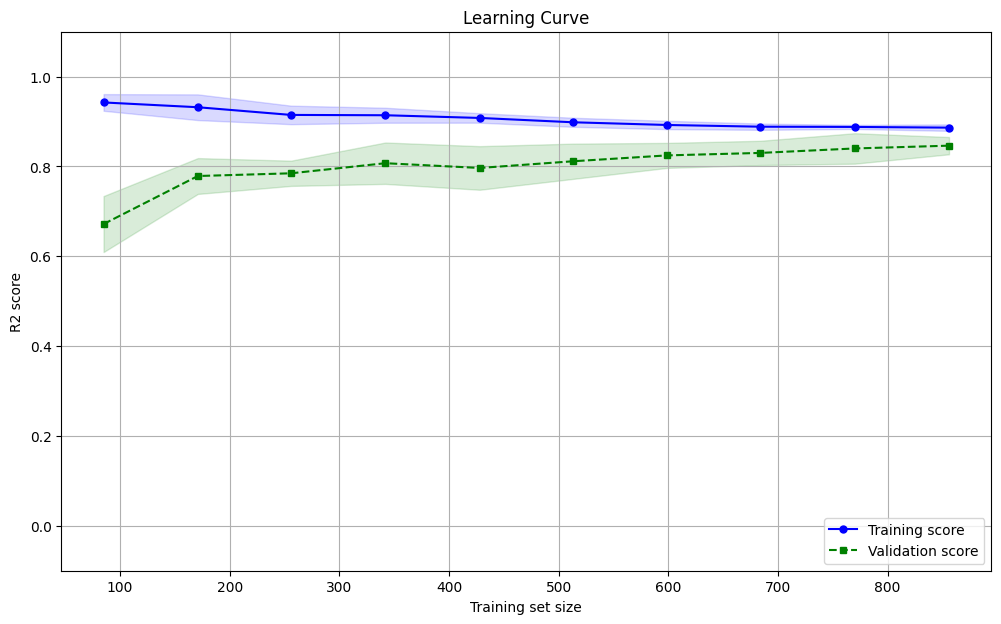

In [ ]:
model = dtr_best_model

# Learning curve for the best estimator
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    scoring='r2',
    shuffle=True
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
fig, ax = plt.subplots(figsize=(12, 7))

# Training score curve
ax.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

# Validation score curve
ax.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

# Customizing the plot
ax.set_xlabel('Training set size')
ax.set_ylabel('R2 score')  # Label for R2 score
ax.set_title('Learning Curve')
ax.legend(loc='lower right')
ax.grid()
ax.set_ylim([-0.1, 1.1])

plt.show()

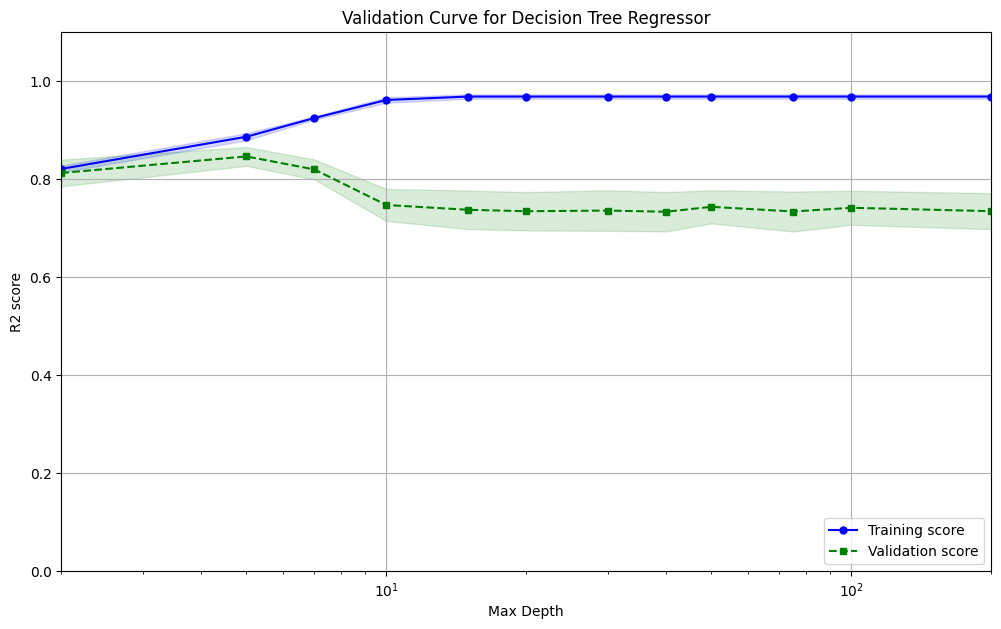

In [ ]:
# Define the parameter range for 'n_estimators'
range_n_estimators = [2,5,7,10,15,20,30,40,50,75,100,200]


model = dtr_best_model

# Validation curve for 'n_estimators'
train_scores, test_scores = validation_curve(
    model,
    X=X_train,
    y=y_train,
    param_name='regressor__max_depth',
    param_range=range_n_estimators,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
fig, ax = plt.subplots(figsize=(12, 7))

# Training score curve
ax.plot(range_n_estimators, train_mean, color='blue', marker='o', markersize=5, label='Training score')
ax.fill_between(range_n_estimators, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

# Validation score curve
ax.plot(range_n_estimators, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
ax.fill_between(range_n_estimators, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

# Customizing the plot
ax.set_xlabel('Max Depth')
ax.set_ylabel('R2 score')
ax.set_title('Validation Curve for Decision Tree Regressor')
ax.legend(loc='lower right')
ax.grid()
ax.set_ylim([0.0, 1.1])
ax.set_xscale('log')
ax.set_xlim([min(range_n_estimators), max(range_n_estimators)])

plt.show()

In fact in our model we set max depth = 5, which is the moment in the graph were the two curves are overlapped. Further incrementing the max depth increases the trainingo score but slightly decreases the validation score. This proves that in our hyperparameter engineering phase we made the best one.

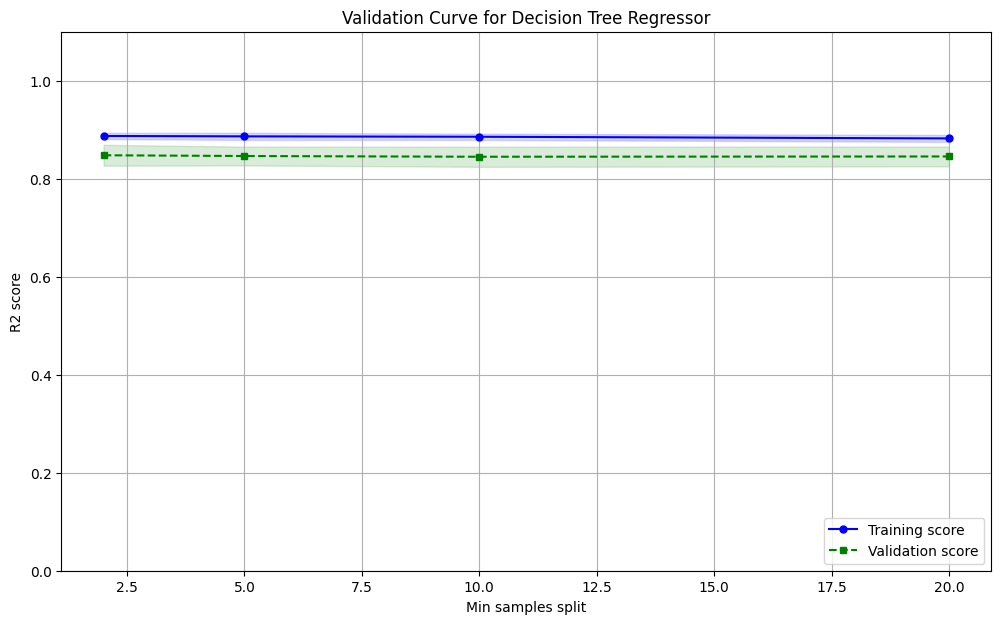

In [ ]:
range_min_samples_split = [2, 5, 10, 20]

# Validation curve for 'min_samples_split'
train_scores, test_scores = validation_curve(
    model,
    X=X_train,
    y=y_train,
    param_name='regressor__min_samples_split',
    param_range=range_min_samples_split,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
fig, ax = plt.subplots(figsize=(12, 7))

# Training score curve
ax.plot(range_min_samples_split, train_mean, color='blue', marker='o', markersize=5, label='Training score')
ax.fill_between(range_min_samples_split, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

# Validation score curve
ax.plot(range_min_samples_split, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
ax.fill_between(range_min_samples_split, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

# Customizing the plot
ax.set_xlabel('Min samples split')
ax.set_ylabel('R2 score')
ax.set_title('Validation Curve for Decision Tree Regressor')
ax.legend(loc='lower right')
ax.grid()
ax.set_ylim([0.0, 1.1])


plt.show()

The best seems to be min_samples_split = 5

# Neural Model

Just to see potentially how much the score could improve I implemented a simple neural model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
X_transformed = final_transformation.fit_transform(X)

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# train
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# predict
y_pred = model.predict(X_test)

# evaluate using R² score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Epoch 1/100
27/27 [==============================] - 2s 14ms/step - loss: 325450784.0000 - val_loss: 310322080.0000
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 325380448.0000 - val_loss: 310220576.0000
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 325222816.0000 - val_loss: 309994976.0000
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 324877920.0000 - val_loss: 309536960.0000
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 324220704.0000 - val_loss: 308691456.0000
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 323075392.0000 - val_loss: 307308128.0000
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 321269248.0000 - val_loss: 305234944.0000
Epoch 8/100
27/27 [==============================] - 0s 3ms/step - loss: 318646912.0000 - val_loss: 302249920.0000
Epoch 9/100
27/27 [==============================] - 0s 3ms/step - loss: 315030

Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 38786804.0000 - val_loss: 36811880.0000
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 38633208.0000 - val_loss: 36595800.0000
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 38490048.0000 - val_loss: 36433840.0000
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 38354204.0000 - val_loss: 36260056.0000
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 38248696.0000 - val_loss: 36139268.0000
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 38149392.0000 - val_loss: 35937452.0000
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 38053296.0000 - val_loss: 35843940.0000
Epoch 8/100
27/27 [==============================] - 0s 4ms/step - loss: 37971732.0000 - val_loss: 35744476.0000
Epoch 9/100
27/27 [==============================] - 0s 5ms/step - loss: 37889628.0000 - val_los

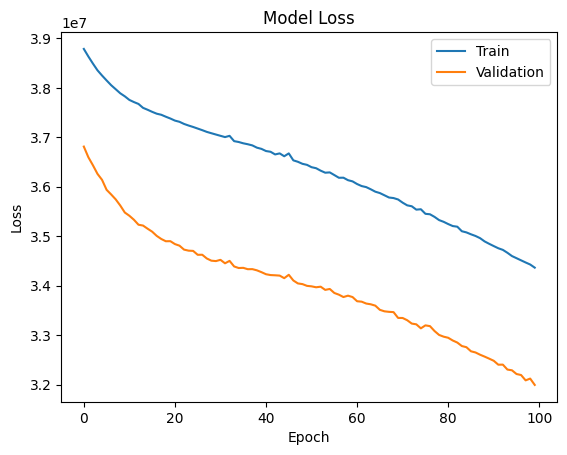

In [ ]:
# Train the model and store the history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

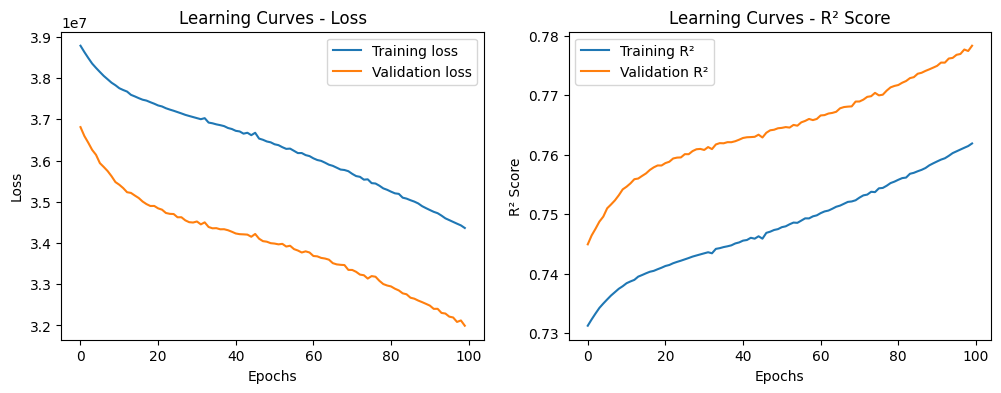

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curves - Loss')

    # Plot R2
    r2_train = 1 - history.history['loss'] / np.var(y_train)
    r2_val = 1 - history.history['val_loss'] / np.var(y_train)
    plt.subplot(1, 2, 2)
    plt.plot(r2_train, label='Training R²')
    plt.plot(r2_val, label='Validation R²')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score')
    plt.legend()
    plt.title('Learning Curves - R² Score')

    plt.show()

# Plot learning curves for the current training process
plot_learning_curves(history)

Epoch 1/200
27/27 [==============================] - 1s 9ms/step - loss: 325420256.0000 - val_loss: 310229664.0000
Epoch 2/200
27/27 [==============================] - 0s 4ms/step - loss: 325064192.0000 - val_loss: 309472128.0000
Epoch 3/200
27/27 [==============================] - 0s 4ms/step - loss: 323196256.0000 - val_loss: 306019552.0000
Epoch 4/200
27/27 [==============================] - 0s 4ms/step - loss: 316170944.0000 - val_loss: 294490688.0000
Epoch 5/200
27/27 [==============================] - 0s 4ms/step - loss: 296494112.0000 - val_loss: 266603552.0000
Epoch 6/200
27/27 [==============================] - 0s 4ms/step - loss: 255460800.0000 - val_loss: 217548448.0000
Epoch 7/200
27/27 [==============================] - 0s 4ms/step - loss: 196481296.0000 - val_loss: 161504784.0000
Epoch 8/200
27/27 [==============================] - 0s 4ms/step - loss: 145291760.0000 - val_loss: 129495640.0000
Epoch 9/200
27/27 [==============================] - 0s 5ms/step - loss: 1246947

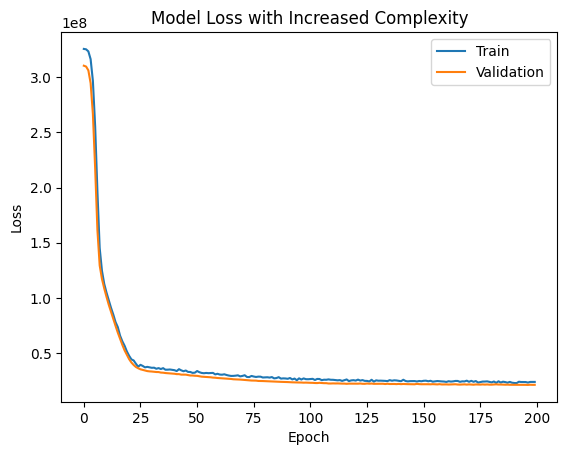

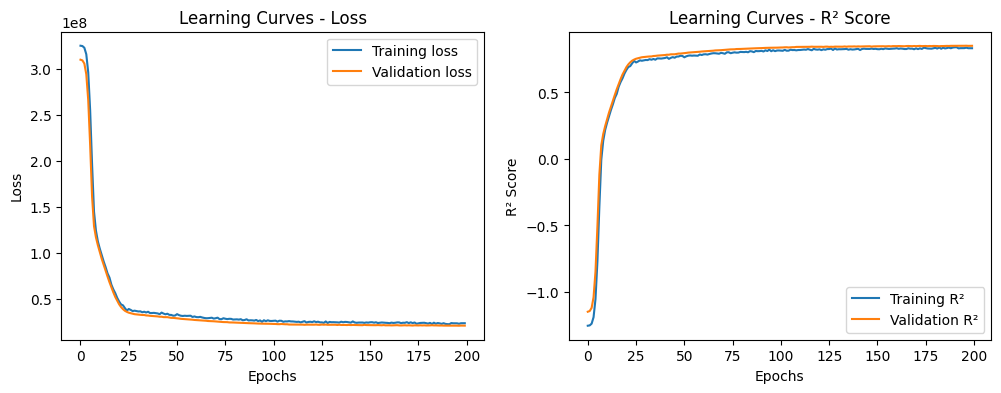

9/9 [==============================] - 0s 3ms/step
R² Score: 0.877534023547556


In [ ]:
# define the neural network model with increased complexity and reduced regularization
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

# plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss with Increased Complexity')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# learning curves for the current training process
plot_learning_curves(history)

# predict on test set
y_pred = model.predict(X_test)

# evaluate the model using R² score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

# Conclusion

The final model chosen for this task was decision tree regression,  which gave a score of 0.828. This model was chosen instead of random forest regressor as the latter was performing large overfitting on the data.
Some further improvements that could be made include:
- dealing with outliers
  - trimming/capping or winsorization
  - Z-score and IQR method
- experimenting with robust regression, that could also help for outlier treatment
- dealing with overfitting of random forest